Original class counts:
Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64


Training Progress:   0%|                                                   | 0/1000 [00:00<?, ?it/s]

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 11

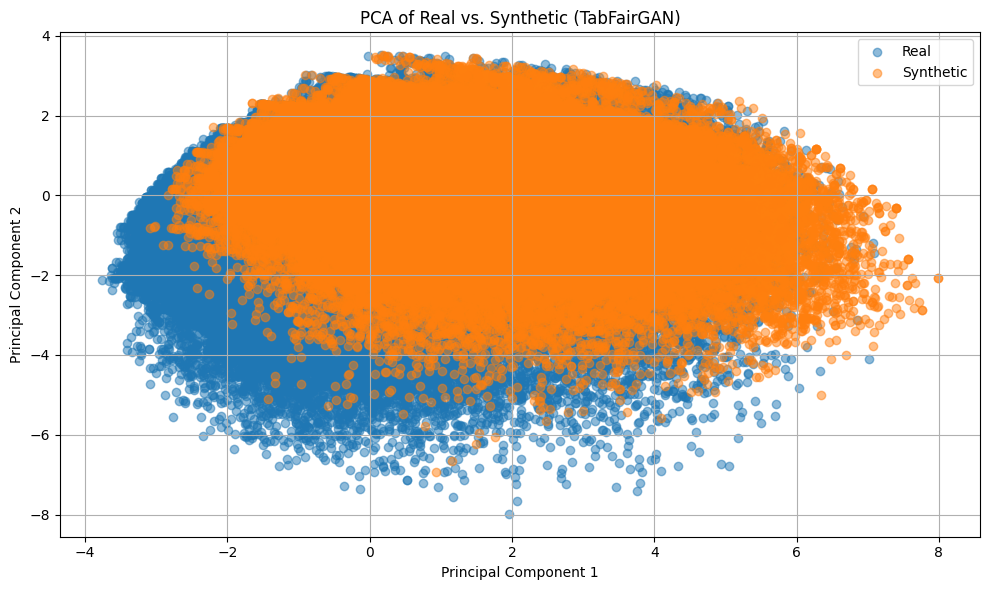

In [17]:
import pandas as pd
import torch
from tabfairgan import TFG
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ── 1) Load & preprocess real data ───────────────────────────────────────────────
df = pd.read_csv('Diabetes.csv')
TARGET = 'Diabetes_binary'

# TabFairGAN requirement: sensitive & target columns as strings
df['Sex'] = pd.to_numeric(df['Sex'], errors='coerce').fillna(0).astype(int).astype(str)
df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce').fillna(0).astype(int).astype(str)

print("Original class counts:")
print(df[TARGET].value_counts())

# ── 2) Set up fairness config & device ───────────────────────────────────────────
fairness_config = {
    'fair_epochs': 50,
    'lamda': 1.0,
    'S': 'Sex',
    'Y': TARGET,
    'S_under': '0',     # under‑privileged group (female)
    'Y_desire': '1'     # desired outcome ( no diabetes)
}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# ── 3) Train TabFairGAN ──────────────────────────────────────────────────────────
tfg = TFG(df,
          epochs=1000,
          batch_size=256,
          device=device,
          fairness_config=fairness_config)
tfg.train()

# ── 4) Calculate how many minority samples to generate ────────────────────────────
is_minority = (df['Sex'] == '0') & (df[TARGET] == '1')
n_real_min = df[is_minority].shape[0]
n_real_maj = df.shape[0] - n_real_min

n_to_generate = n_real_maj - n_real_min
print(f"Need {n_to_generate} synthetic minority samples to balance.")

# ── 5) Generate and filter synthetic minority ────────────────────────────────────
syn = tfg.generate_fake_df(num_rows=n_to_generate * 5)

# Convert synthetic columns to strings for consistent filtering
syn['Sex'] = syn['Sex'].astype(str)
syn[TARGET] = syn[TARGET].astype(str)

# Print generated distribution for debug
print("\nGenerated synthetic data distribution:")
print(syn.groupby(['Sex', TARGET]).size())

# Filter for underprivileged desired outcome
syn_min = syn[(syn['Sex'] == '0') & (syn[TARGET] == '1')].iloc[:n_to_generate]
print("Synthetic minority obtained:", syn_min.shape[0])

# ── ADDED: Label the data before combining ──────────────────────────────────────
# Add DataType column to distinguish real vs synthetic
df['source'] = 'Real'  # Label original data as Real
syn_min['source'] = 'Synthetic'  # Label synthetic data as Synthetic

# Save synthetic minority samples only (with source label)
syn_min.to_csv("TabFairGAN_synthetic_minority_01.csv", index=False)
print("Synthetic minority samples saved to TabFairGAN_synthetic_minority_01.csv")

# ── Combine original data with synthetic minority to form balanced dataset ──
df_balanced = pd.concat([df, syn_min], ignore_index=True)

print("Balanced dataset shape:", df_balanced.shape)
print(df_balanced[TARGET].value_counts())

# Check source distribution
print("\n source distribution in balanced dataset:")
print(df_balanced['source'].value_counts())

# Convert categorical columns safely from string to int for consistency
df_balanced[TARGET] = pd.to_numeric(df_balanced[TARGET], errors='coerce').fillna(0).astype(int)
df_balanced['Sex'] = pd.to_numeric(df_balanced['Sex'], errors='coerce').fillna(0).astype(int)

print("Class distribution (after conversion):")
print(df_balanced[TARGET].value_counts())
print(f"Total samples: {len(df_balanced)}")

# Save the cleaned and balanced dataset (with DataType column)
df_balanced.to_csv("`.csv", index=False)
print("Balanced dataset saved to TabFairGAN_balanced_diabetes.csv")

# ── Fairness Metric Functions with zero-division protection ──────────────────────

def safe_rate(numerator, denominator):
    return numerator / denominator if denominator > 0 else 0.0

def disparate_impact(df, S, Y, s_priv, s_unpriv, desired_outcome):
    priv_total = df[df[S] == s_priv].shape[0]
    unpriv_total = df[df[S] == s_unpriv].shape[0]

    p_priv   = safe_rate(df[(df[S] == s_priv) & (df[Y] == desired_outcome)].shape[0], priv_total)
    p_unpriv = safe_rate(df[(df[S] == s_unpriv) & (df[Y] == desired_outcome)].shape[0], unpriv_total)

    return safe_rate(p_unpriv, p_priv)

def demographic_parity_diff(df, S, Y, s_priv, s_unpriv, desired_outcome):
    priv_total = df[df[S] == s_priv].shape[0]
    unpriv_total = df[df[S] == s_unpriv].shape[0]

    p_priv   = safe_rate(df[(df[S] == s_priv) & (df[Y] == desired_outcome)].shape[0], priv_total)
    p_unpriv = safe_rate(df[(df[S] == s_unpriv) & (df[Y] == desired_outcome)].shape[0], unpriv_total)

    return abs(p_priv - p_unpriv)

def print_fairness_metrics(df, S='Sex', Y='Diabetes_binary', s_under='0', s_over='1', desired='1'):
    di = disparate_impact(df, S, Y, s_priv=s_over, s_unpriv=s_under, desired_outcome=desired)
    dp = demographic_parity_diff(df, S, Y, s_priv=s_over, s_unpriv=s_under, desired_outcome=desired)
    print(f"\n⚖️  Fairness Metrics for synthetic data:")
    print(f"  - Disparate Impact:           {di:.4f}")
    print(f"  - Demographic Parity Diff:    {dp:.4f}")
    if 0.8 <= di <= 1.25:
        print("  Disparate Impact is in the acceptable '80% rule' range.")
    else:
        print("  Disparate Impact is outside the fair range.")

def print_group_counts(df, S, Y):
    print("\nGroup counts for [Sensitive, Target]:")
    print(df.groupby([S, Y]).size())

# Print group counts for debugging
print_group_counts(df_balanced, 'Sex', 'Diabetes_binary')

# Calculate and print fairness metrics on balanced dataset
print_fairness_metrics(df_balanced, S='Sex', Y='Diabetes_binary', s_under='0', s_over='1', desired='0')

# ── ADDED: Additional analysis on source ──────────────────────────────────────
print("\n" + "="*50)
print("DATA TYPE ANALYSIS")
print("="*50)

# Check distribution by source
print("\nTarget distribution by source:")
print(df_balanced.groupby(['source', TARGET]).size().unstack(fill_value=0))

print("\nSensitive attribute distribution by source:")
print(df_balanced.groupby(['source', 'Sex']).size().unstack(fill_value=0))

# ── PCA Visualization function ────────────────────────────────────────────────────

def plot_pca_real_vs_synthetic(real_df, synth_df, features, label_col=None, title='PCA of Real vs. Synthetic (TabFairGAN)'):
    # Standardize features
    scaler = StandardScaler()
    all_data = pd.concat([real_df[features], synth_df[features]], axis=0)
    scaled_all = scaler.fit_transform(all_data)

    # PCA 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_all)

    # Create DataFrame for plot
    n_real = len(real_df)
    n_synth = len(synth_df)
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['source'] = ['Real'] * n_real + ['Synthetic'] * n_synth

    if label_col:
        pca_df['Label'] = pd.concat([real_df[label_col], synth_df[label_col]], axis=0).astype(str).values

    plt.figure(figsize=(10, 6))
    for dtype in ['Real', 'Synthetic']:
        subset = pca_df[pca_df['source'] == dtype]
        plt.scatter(subset['PC1'], subset['PC2'], label=f"{dtype}", alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage of PCA visualization:
# Define features for PCA (exclude sensitive and target columns or categorical)
features = [col for col in df.columns if col not in ['Sex', TARGET, 'source']]  # Exclude source for PCA

# For PCA, use the original df (without source) and syn_min
df_for_pca = df.drop(columns=['source'], errors='ignore')  # Remove source if exists
plot_pca_real_vs_synthetic(df_for_pca, syn_min, features, label_col=TARGET)

In [25]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

# 1. CONFIGURATION
TARGET = 'Diabetes_binary'
MINORITY_CLASS = 1
SYNTHETIC_PATH = 'TabFairGAN_balanced_diabetes_final.csv'

# 2. LOAD DATA
df = pd.read_csv('Diabetes.csv')
synthetic_df = pd.read_csv(SYNTHETIC_PATH)

# 3. JSD CALCULATION FUNCTION
def compute_jsd(p, q, bins=50):
    """Calculate Jensen-Shannon Divergence between two distributions"""
    range_min = min(np.min(p), np.min(q))
    range_max = max(np.max(p), np.max(q))
    
    p_hist, _ = np.histogram(p, bins=bins, range=(range_min, range_max), density=True)
    q_hist, _ = np.histogram(q, bins=bins, range=(range_min, range_max), density=True)
    
    p_hist = np.maximum(p_hist, 1e-10)
    q_hist = np.maximum(q_hist, 1e-10)
    
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    
    return distance.jensenshannon(p_hist, q_hist)

# 4. CALCULATE JSD FOR EACH FEATURE

print("\nJSD Evaluation of TabFairGANN:\n")
print("{:<20} {:<10}".format('Feature', 'JSD Score'))
print("-" * 30)

# Get numeric columns (exclude target and source)
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in [TARGET, 'source']]

# Filter for diabetes cases
synthetic_minority = synthetic_df[(synthetic_df['source'] == 'Synthetic') & (synthetic_df[TARGET] == 1)]
real_minority = df[df[TARGET] == 1]


for col in numeric_cols:
    real_data = real_minority[col].dropna().values
    synth_data = synthetic_minority[col].dropna().values
    
    # Skip if not enough data
    if len(real_data) < 10 or len(synth_data) < 10:
        continue
        
    jsd = compute_jsd(real_data, synth_data)
    print("{:<20} {:<10.4f}".format(col, jsd))

# 5. INTERPRETATION GUIDE
print("\nJSD Interpretation Guide:")
print("0.0 - 0.05: Excellent match")
print("0.05 - 0.1: Very good match")
print("0.1 - 0.2: Reasonable match")
print("0.2 - 0.3: Noticeable differences")
print("> 0.3: Significant differences")


JSD Evaluation of TabFairGANN:

Feature              JSD Score 
------------------------------
HighBP               0.0069    
HighChol             0.0304    
CholCheck            0.0071    
BMI                  0.2625    
Smoker               0.0483    
Stroke               0.0611    
HeartDiseaseorAttack 0.0405    
PhysActivity         0.0080    
Fruits               0.0227    
Veggies              0.0049    
HvyAlcoholConsump    0.0907    
AnyHealthcare        0.0283    
NoDocbcCost          0.0066    
GenHlth              0.1054    
MentHlth             0.1269    
PhysHlth             0.0905    
DiffWalk             0.0403    
Sex                  0.4521    
Age                  0.1060    
Education            0.3454    
Income               0.1416    

JSD Interpretation Guide:
0.0 - 0.05: Excellent match
0.05 - 0.1: Very good match
0.1 - 0.2: Reasonable match
0.2 - 0.3: Noticeable differences
> 0.3: Significant differences


Binary features identified: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

JSD Evaluation of TabFairGAN:

Feature              JSD Score 
------------------------------
HighBP               0.0061    
HighChol             0.0304    
CholCheck            0.0071    
BMI                  0.2625    
Smoker               0.0483    
Stroke               0.0605    
HeartDiseaseorAttack 0.0399    
PhysActivity         0.0080    
Fruits               0.0227    
Veggies              0.0049    
HvyAlcoholConsump    0.0907    
AnyHealthcare        0.0283    
NoDocbcCost          0.0032    
GenHlth              0.1054    
MentHlth             0.1269    
PhysHlth             0.0905    
DiffWalk             0.0379    
Sex                  0.4521    
Age                  0.1060    
Education            0.3454    
Income               0.1416    

Quality Assessm

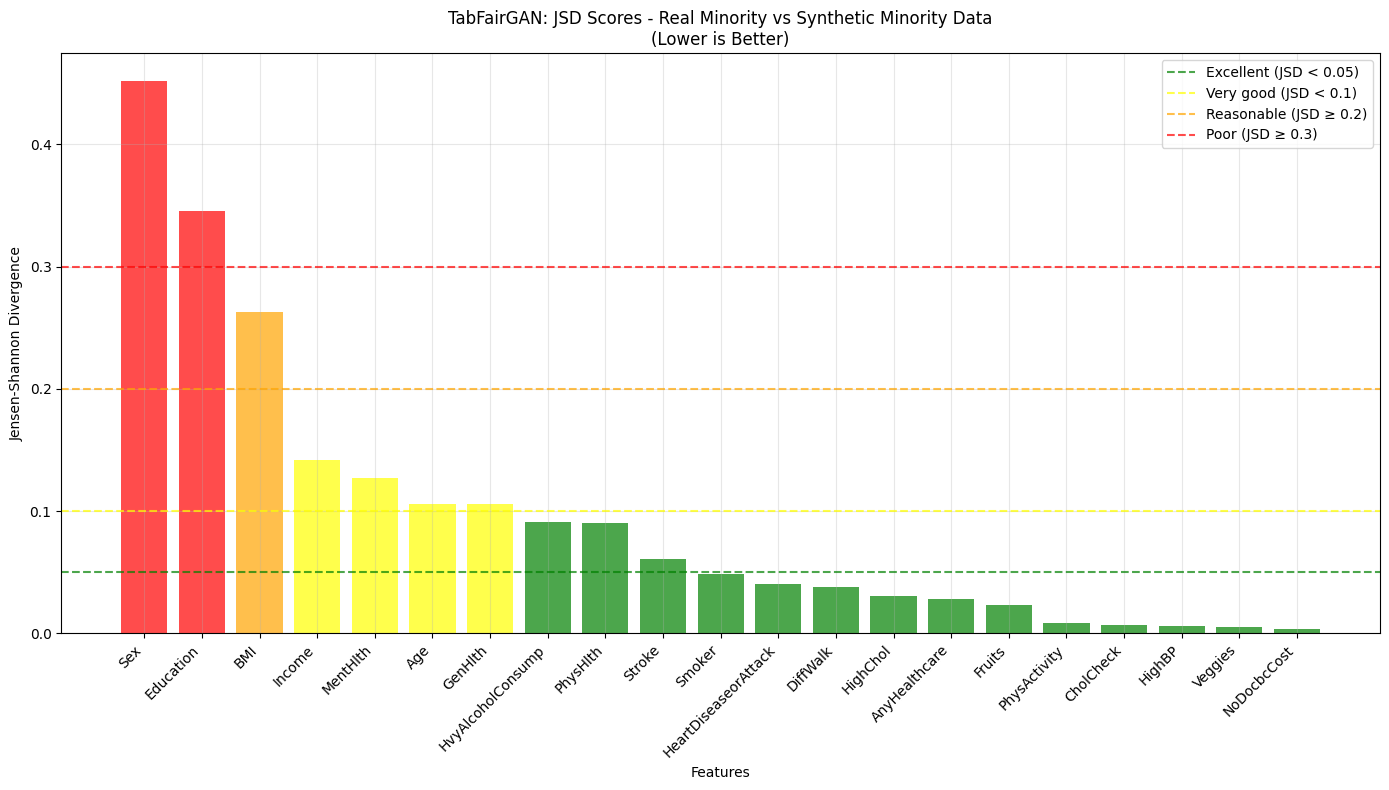


JSD INTERPRETATION GUIDE
0.0 - 0.05: Excellent match (distributions are almost identical)
0.05 - 0.1: Very good match (minor differences)
0.1 - 0.2: Reasonable match (some noticeable differences)
0.2 - 0.3: Noticeable differences (distributions differ)
> 0.3: Significant differences (poor match)


In [34]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

# 1. CONFIGURATION
TARGET = 'Diabetes_binary'
MINORITY_CLASS = 1
DATA_PATH = 'TabFairGAN_balanced_diabetes_final.csv'
THRESHOLD = 0.5

# 2. LOAD DATA
df = pd.read_csv(DATA_PATH)

# 3. THRESHOLD SYNTHETIC DATA (MODIFIED FOR TabFairGAN)
def threshold_synthetic_data(df, threshold=0.5):
    """Convert continuous synthetic outputs to binary for categorical features"""
    binary_features = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col == TARGET: 
            continue
        # Look at REAL data to determine if feature is binary
        unique_vals = df[df['source'] == 'Real'][col].unique()  # Capital R
        if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
            binary_features.append(col)
    
    print(f"Binary features identified: {binary_features}")
    
    # Apply thresholding to synthetic data only
    synth_mask = df['source'] == 'Synthetic'  # Capital S
    for feature in binary_features:
        df.loc[synth_mask, feature] = (df.loc[synth_mask, feature] > threshold).astype(float)
    
    return df

# APPLY THRESHOLDING
df = threshold_synthetic_data(df)

# 4. JSD CALCULATION FUNCTION
def compute_jsd(p, q, bins=50):
    """Calculate Jensen-Shannon Divergence between two distributions"""
    range_min = min(np.min(p), np.min(q))
    range_max = max(np.max(p), np.max(q))
    p_hist, _ = np.histogram(p, bins=bins, range=(range_min, range_max), density=True)
    q_hist, _ = np.histogram(q, bins=bins, range=(range_min, range_max), density=True)
    p_hist = np.maximum(p_hist, 1e-10)
    q_hist = np.maximum(q_hist, 1e-10)
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    return distance.jensenshannon(p_hist, q_hist)

# 5. CALCULATE JSD FOR EACH FEATURE (MODIFIED FOR TabFairGAN)
print("\nJSD Evaluation of TabFairGAN:\n")
print("{:<20} {:<10}".format('Feature', 'JSD Score'))
print("-" * 30)

numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET)
jsd_results = []

for col in numeric_cols:
    # REAL minority data (source == 'Real' for TabFairGAN)
    real_data = df[(df['source'] == 'Real') & (df[TARGET] == MINORITY_CLASS)][col].values
    
    # SYNTHETIC data (source == 'Synthetic' for TabFairGAN)
    synth_data = df[df['source'] == 'Synthetic'][col].values
    
    if len(real_data) == 0 or len(synth_data) == 0:
        print(f"{col}: Skipped (no data)")
        continue
        
    jsd = compute_jsd(real_data, synth_data)
    jsd_results.append((col, jsd))
    print("{:<20} {:<10.4f}".format(col, jsd))

# 6. QUALITY ASSESSMENT
jsd_scores = [score for _, score in jsd_results]
total_features = len(jsd_scores)
excellent_match = sum(1 for score in jsd_scores if score < 0.05)
good_match = sum(1 for score in jsd_scores if score < 0.1)

print(f"\nQuality Assessment:")
print(f"Excellent matches (JSD < 0.05): {excellent_match}/{total_features} ({excellent_match/total_features:.1%})")
print(f"Good matches (JSD < 0.1): {good_match}/{total_features} ({good_match/total_features:.1%})")
print(f"Poor matches (JSD >= 0.1): {total_features - good_match}/{total_features} ({(total_features - good_match)/total_features:.1%})")

# 7. VISUALIZATION
plt.figure(figsize=(14, 8))
features, scores = zip(*sorted(jsd_results, key=lambda x: x[1], reverse=True))

colors = [
    'red' if score >= 0.3 else 
    'orange' if score >= 0.2 else 
    'yellow' if score >= 0.1 else 
    'green' 
    for score in scores
]

bars = plt.bar(range(len(features)), scores, color=colors, alpha=0.7)

plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (JSD < 0.05)')
plt.axhline(y=0.1, color='yellow', linestyle='--', alpha=0.7, label='Very good (JSD < 0.1)')
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Reasonable (JSD ≥ 0.2)')
plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='Poor (JSD ≥ 0.3)')


plt.xlabel('Features')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('TabFairGAN: JSD Scores - Real Minority vs Synthetic Minority Data\n(Lower is Better)')
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. INTERPRETATION GUIDE
print("\n" + "="*60)
print("JSD INTERPRETATION GUIDE")
print("="*60)
print("0.0 - 0.05: Excellent match (distributions are almost identical)")
print("0.05 - 0.1: Very good match (minor differences)")
print("0.1 - 0.2: Reasonable match (some noticeable differences)")
print("0.2 - 0.3: Noticeable differences (distributions differ)")
print("> 0.3: Significant differences (poor match)")

In [35]:
import pandas as pd

# Load your dataset (example with a CSV file)
df = pd.read_csv('TabFairGAN_balanced_diabetes_final.csv')

# Method 1: Use the .shape attribute
# .shape returns a tuple (number_of_rows, number_of_columns)
num_rows = df.shape[0]
print(f"The dataset has {num_rows} rows.")

# Method 2: Use the len() function
# The len() of a DataFrame returns the number of rows
num_rows = len(df)
print(f"The dataset has {num_rows} rows.")

# Method 3: Use the .index attribute
# The length of the DataFrame's index is the number of rows
num_rows = len(df.index)
print(f"The dataset has {num_rows} rows.")

The dataset has 347119 rows.
The dataset has 347119 rows.
The dataset has 347119 rows.
